<h1 style="color:#191970; font-size:38px">MIMO-NN1</h1>

<h1 style="color:#006400">Tools</h1>

<h1 style="color:#FF5733 ; font-size:15px"> CommPy</h1> is an open source toolkit implementing digital communications algorithms in Python using NumPy and SciPy.

In [1]:
pip install scikit-commpy

Note: you may need to restart the kernel to use updated packages.


<h1 style="color:#006400">Libraries</h1>

In [73]:
from statistics import mean
import numpy as np
from numpy.random import *
from numpy import *
from numpy.linalg import inv
from commpy.utilities import *
from commpy.modulation import QAMModem
from commpy.channels import *
from commpy.links import *
from math import *
import matplotlib.pyplot as plt
import time 

<h1 style="color:#006400">Functions</h1>

### 1. High Power Amplifier Output  

In [74]:
def hpa_sspa_modif_rapp(vin,Vsat,p,q,G,A,B):
    A=-345
    a0=abs(vin)
    theta=np.angle(vin)
    Am=(G*a0)/((1+(G*a0/Vsat)**(2*p))**(1/(2*p)))
    Bm=(A*(a0**q))/((1+(a0/B)**(q)))
    vout=Am*np.exp(1j*(theta+Bm))
    return(vout)
    

### 2. Non Linear Distortion Parameters  

In [75]:
def find_K0_sigma2_d(vin,vout):
    K0 = np.mean(vout*np.conj(vin))/np.mean(np.absolute(vin)**2)
    sigma2_d = np.var(vout - K0*vin)
    return(K0,sigma2_d)

<h1 style="color:#006400">Basic PA Non linear Distortion Model </h1>

In [76]:
IBO=1
p=1.1
q=4
Vsat=1.9
G=16
A=-345
B=0.17
val_IBO_m1dB=((1/np.sqrt(10**-0.1))**(2*p)-1)**(1/(2*p))*Vsat/(G)
coeff_IBO_m1dB=val_IBO_m1dB*np.sqrt(10**(-IBO/10))
s=np.random.randn(1,1000000)
vin1 = np.sqrt(1/2)*(s+1j*s)
vin01 = coeff_IBO_m1dB*vin1
a0=np.absolute(vin01)
a02=a0**2  
theta=np.angle(vin01)
Am=(G*a0)/((1+(G*a0/Vsat)**(2*p))**(1/(2*p)))
Bm=(A*(a0**q))/((1+(a0/B)**(q)))
Sm=Am*np.exp(1j*(Bm))
vout1=Am*np.exp(1j*(theta+Bm))
K0 = np.mean(vout1*np.conj(vin01))/np.mean(np.absolute(vin01)**2)
sigma2_d = np.var(vout1 - K0*vin01) 
print(K0)
print(sigma2_d)

(12.808648611229737-0.4425297486173269j)
0.013454168638490919


<h1 style="color:#006400">Training Dataset </h1>

In [ ]:
Mr=10
Mt=100
M=16
SNRdb=600
N_bits=Mr*np.log2(M)
MSE=np.zeros((Mt,50))
x_gd_amp0=np.zeros((Mt,1))
y_gd_r0=np.zeros([Mt,100])
PAPR_GD=np.zeros((Mt,1))
MUIgdi= np.zeros((Mt,1))
SERgdi=np.zeros((Mt,1))
BERgdi=np.zeros((Mt,1))
GD_Execution_time=0
HH=np.zeros((1,2000))
S=np.zeros((165000,20))
ZZ=np.zeros((165000,10),dtype=complex)
Niter=50
mu1=0.0022
lamda=0.00071
mu2=1
eps=1e-2
x_gd=np.zeros([Mt,1])
X_gd=np.zeros((165000,100))
gdx1=np.zeros([Mt,Niter])
d=np.zeros([Mt,1])
X=np.zeros((165000,200))
H=(1/np.sqrt(2*Mt))*(np.random.randn(Mr,Mt)+1j*np.random.randn(Mr,Mt))
HR=H.flatten()
realh=np.real(HR)
imagh=np.imag(HR)
Hr=np.concatenate((realh,imagh),axis=0).reshape(-1,1)
Hr=np.reshape(Hr, (2000, 1)).T
HH=Hr
for j in range(165000):
    bits = np.random.randint(2, size=int(N_bits))
    QAM16 = QAMModem(16)
    z=QAM16.modulate(bits)
    Z = np.reshape(z, (1, 10)).T
    ZZ[j]=Z.T
    reals=np.real(Z.T)
    imags=np.imag(Z.T)
    s=np.concatenate((reals,imags),axis=1)
    S[j]=s
    ## CDm algo
    for i in range(Niter):
        gdx1=2*np.conj(K0*np.transpose(H)).dot(K0*H.dot(x_gd)+H.dot(d)-Z)
        x_gd=x_gd-mu1*gdx1
        realx=np.real( x_gd)
        imagx=np.imag( x_gd)
        x_z=np.concatenate((realx,imagx),axis=0).T
        X[j]=x_z
        ## HPA 
        val_IBO_m1dB=((1/np.sqrt(10**-0.1))**(2*p)-1)**(1/(2*p))*Vsat/(G)
        coeff_IBO_m1dB=val_IBO_m1dB*np.sqrt((1/np.var(x_gd)))*np.sqrt(10**(-IBO/10))
        vin2=coeff_IBO_m1dB*x_gd
        vout2=hpa_sspa_modif_rapp(vin2,Vsat,p,q,G,A,B)
        K0,sigma2_d=find_K0_sigma2_d (vin2,vout2)
        d=vout2-K0*vin2
        y_gd =np.array(vout2/coeff_IBO_m1dB)
print(X)        

<h1 style="color:#006400"> Data Normalization </h1>

In [ ]:
X_train=S[:200000,:]
y_train=X[:200000,:]

X_test=S[200000:,:]
y_test=X[200000:,:] 


<h1 style="color:#006400"> Artifical Neural Network</h1>

In [65]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout, Activation, BatchNormalization
import matplotlib.pyplot as plt
model = Sequential()
#keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.1, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)
model.add(Dense(units =3000, kernel_initializer = 'uniform', activation = 'relu', input_dim =20))
model.add(Dense(units =200, kernel_initializer = 'uniform', activation = 'selu'))
model.compile(optimizer = 'Adamax', loss = 'mae', metrics = ['accuracy'])
history =model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=10000, epochs=500, shuffle=False)


Train on 163000 samples, validate on 2000 samples
Epoch 1/500
163000/163000 [==============================] - 11s 69us/step - loss: 0.2359 - accuracy: 0.0190 - val_loss: 0.1855 - val_accuracy: 0.0270
Epoch 2/500
163000/163000 [==============================] - 7s 45us/step - loss: 0.1442 - accuracy: 0.0262 - val_loss: 0.0872 - val_accuracy: 0.0500
Epoch 3/500
163000/163000 [==============================] - 7s 42us/step - loss: 0.0873 - accuracy: 0.0380 - val_loss: 0.0840 - val_accuracy: 0.0300
Epoch 4/500
163000/163000 [==============================] - 7s 41us/step - loss: 0.0646 - accuracy: 0.0775 - val_loss: 0.0633 - val_accuracy: 0.0555
Epoch 5/500
163000/163000 [==============================] - 7s 41us/step - loss: 0.0557 - accuracy: 0.0643 - val_loss: 0.0422 - val_accuracy: 0.1340
Epoch 6/500
163000/163000 [==============================] - 7s 40us/step - loss: 0.0434 - accuracy: 0.1253 - val_loss: 0.0367 - val_accuracy: 0.2335
Epoch 7/500
163000/163000 [======================

Epoch 55/500
163000/163000 [==============================] - 8s 47us/step - loss: 0.0112 - accuracy: 0.7309 - val_loss: 0.0111 - val_accuracy: 0.7185
Epoch 56/500
163000/163000 [==============================] - 8s 47us/step - loss: 0.0111 - accuracy: 0.7339 - val_loss: 0.0111 - val_accuracy: 0.7285
Epoch 57/500
163000/163000 [==============================] - 8s 47us/step - loss: 0.0110 - accuracy: 0.7362 - val_loss: 0.0111 - val_accuracy: 0.7250
Epoch 58/500
163000/163000 [==============================] - 9s 56us/step - loss: 0.0109 - accuracy: 0.7390 - val_loss: 0.0109 - val_accuracy: 0.7345
Epoch 59/500
163000/163000 [==============================] - 7s 45us/step - loss: 0.0108 - accuracy: 0.7404 - val_loss: 0.0109 - val_accuracy: 0.7405
Epoch 60/500
163000/163000 [==============================] - 9s 53us/step - loss: 0.0108 - accuracy: 0.7428 - val_loss: 0.0109 - val_accuracy: 0.7420
Epoch 61/500


KeyboardInterrupt: 

<h1 style="color:#006400"> Weights Vector of NN1</h1>

In [40]:
first_layer_weights =model.layers[0].get_weights()[0] 
first=first_layer_weights.flatten()
first_layer_biases  = model.layers[0].get_weights()[1]
first_layer=np.concatenate((first,first_layer_biases),axis=0)
second_layer_weights = model.layers[1].get_weights()[0]
second=second_layer_weights.flatten()
second_layer_biases  = model.layers[1].get_weights()[1]
second_layer=np.concatenate((second,second_layer_biases),axis=0)
weights=np.concatenate((first_layer,second_layer),axis=0)
print (len(weights))

9040


<h1 style="color:#006400"> Make Predictions</h1>

In [66]:
y_pred= model.predict(X_train)
y_pred_test = model.predict(X_test)


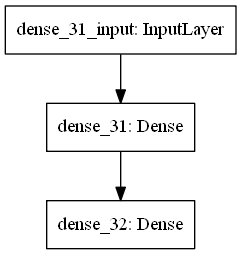

In [116]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

<h1 style="color:#006400"> Accuracy Representation </h1>

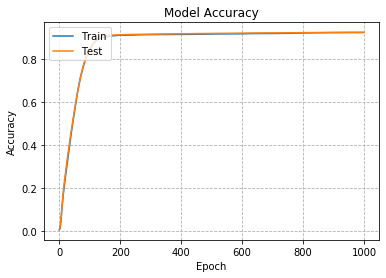

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.grid(True,which="both", linestyle='--')
plt.ylabel('Accuracy') 
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

<h1 style="color:#006400"> Loss Representation</h1>

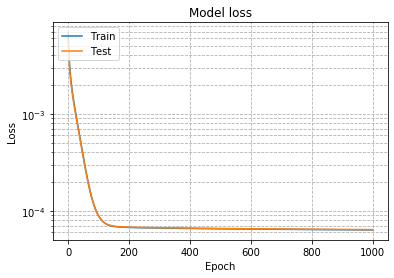

In [29]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.grid(True,which="both", linestyle='--')
plt.ylabel('Loss') 
plt.yscale('log')
plt.xlabel('Epoch')
plt.legend(['Train','Test'], loc='upper left')
plt.show()

<h1 style="color:#006400"> Mean-Squared-Error</h1>

# Test Set 

Mean Squred Error: -21.00731543997059


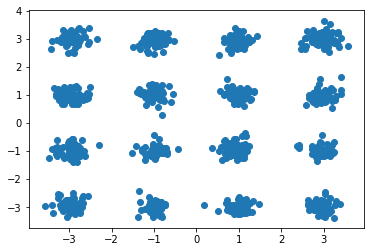

In [67]:
NMSE=np.zeros([100,1])
recievehh=np.zeros([100,10],dtype=complex)
Y_gdr=y_pred_test[:,:100]
Y_gdi=1j*y_pred_test[:,100:]
Y_gd=Y_gdr+Y_gdi
Shr=X_test[:,:10]
Shi=1j*X_test[:,10:20]
SSh=Shr+Shi
for i in range(100):
    val_IBO_m1dB=((1/np.sqrt(10**-0.1))**(2*p)-1)**(1/(2*p))*Vsat/(G)
    coeff_IBO_m1dB=val_IBO_m1dB*np.sqrt((1/np.var(Y_gd[i])))*np.sqrt(10**(-IBO/10))
    vin2=coeff_IBO_m1dB*Y_gd[i]
    vout2=hpa_sspa_modif_rapp(vin2,Vsat,p,q,G,A,B)
    Y_gd_amp = vout2/coeff_IBO_m1dB
    recieveh=(H.dot(Y_gd_amp)).reshape((10))
    recievehh[i]=recieveh
    NMSE[i]=(np.mean(np.abs(SSh[i]-recieveh)**2)/np.mean(np.abs(SSh[i])**2))
    NMSEdb=10*np.log10(np.mean(NMSE[i]))
recievehhh=recievehh.flatten()
realr=np.real(recievehhh)
imagr=np.imag(recievehhh)
plt.scatter(realr,imagr) 

print('Mean Squred Error:', NMSEdb)
